RS eredua dugu kasu honetan. RS ereuduaren ebazpen zuzen bat ikusteko jo 10. Irudiko kodera.

Erabiliko diren moduloak inportatu:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

Erabiliko diren aldagaien laburbilduma

|Aldagaia|Definizioa|Unitatea|
|--------|-----------|-------|
|$t_{max}$ |Simulazioa denbora maximoa|$ms$|
|$\Delta t$|Denboraren diskretizazioa |$ms$|
|$\tau_{max}$ |Parametro esperimentala|$s$|
|$C_{m}$   |Mintz kapazitatea         |$\frac{\mu F}{cm^{2}}$|
|$E_{Na}$  |Inbertsio potentziala, sodio kanaletarako|$mV$|
|$E_{K}$   |Inbertsio potentziala, potasio kanaletarako|$mV$|
|$E_{L}$   |Inbertsi potentziala|$mV$|
|$g_{Na}$  |Konduktantzia espezifikoa, sodio korronte azkarrerako|$\frac{mS}{cm^{2}}$|
|$g_{K}$   |Konduktantzia espezifikoa, potasio korronte iraukorrerako|$\frac{mS}{cm^{2}}$|
|$g_{M}$   |Konduktantzia espezifikoa, potasio korronte geldorako|$\frac{mS}{cm^{2}}$|
|$g_{L}$   |Konduktantzia espezifikoa|$\frac{mS}{cm^{2}}$|
|$i_{mean}$|Batez-besteko intentsitate bat finkatu|$\frac{\mu A}{cm^{2}}$|
|$V_{rest}$|Egoera egonkorreko mintz potentziala|$mV$|
|$V_{Th}$|Atari potentziala|$mV$|

In [2]:
#Parametroak finkatu#####
t_max=400      # ms
delta_t=0.04   # ms
tau_max=500.0     # s
C_m=3.14       # micro F/cm^2 (c_m/(L*d)=C_m)
E_Na=50.00     # mV
E_K=-90.00     # mV
E_L=-70.00     # mV
g_Na=50.0      # mS/cm^2
g_K=5.0        # mS/cm^2
g_M=0.07        # mS/cm^2
g_L=0.1        # mS/cm^2
i_mean=6.5     # microA/cm^2
V_rest=-65.0   # mV
v_th=-40.0     # mV
##########################

### Funtzio laguntzaileen inplementazioa

$$\alpha_{m}=\frac{-0.32(v-v_{Th}-13)}{\exp [-(v-v_{Th}-13)/4]-1}$$

$$\beta_{m}=\frac{0.28(v-v_{Th}-40)}{\exp [(v-v_{Th}-40)/5]-1}$$

$$\alpha_{h}=0.128\exp [-(v-v_{Th}-17)/18]$$

$$\beta_{h}=\frac{4}{1+ exp[-(v-v_{Th}-40)/5]}$$

$$\alpha_{n}=\frac{-0.032(v-v_{Th}-15)}{\exp [-(v-v_{Th}-15)/5]-1}$$

$$\beta_{n}=0.5 \exp[-(v-v_{Th}-10)/40]$$

$$p_{\infty}(v)=\frac{1}{1+\exp[-(v+35)/10]}$$

$$\tau_{p}(v)=\frac{\tau_{max}}{3.3\exp[(v+35)/20]+\exp[-(v+35)/20]}$$

In [3]:

def alpha_m(v):
    return -0.32 * (v - v_th - 13.0) / (np.exp(-(v - v_th - 13.0) / 4.0) - 1.0)

def beta_m(v):
    return 0.28 * (v - v_th - 40.0) / (np.exp((v - v_th - 40.0) / 5.0) - 1.0)

def alpha_h(v):
    return 0.128 * np.exp(-(v - v_th - 17.0)/18.0)

def beta_h(v):
    return 4.0 / (1.0 + np.exp(-(v - v_th - 40.0) / 5.0))

def alpha_n(v):
    return -0.032 * (v - v_th - 15.0) / (np.exp(-(v - v_th - 15.0) / 5.0) - 1.0)

def beta_n(v):
    return 0.5 * np.exp(-(v - v_th - 10.0) / 40.0)

def p_infty(v):
    return 1.0 / (1.0 + np.exp(-(v + 35.0) / 10.0))

def tau_p(v):
    return tau_max / (3.3 * np.exp((v + 35.0) / 20.0) + np.exp(-(v + 35.0) / 20.0))

### Bektoreak eta hasierako balioak finkatu

In [4]:
#Denbora eremu osoa finkatzen dugu. 0 s-tik hasiz, delta_t diskretizazio denbora aldiunez t_max aldiunerarte
t_eremua=np.arange(0,t_max,delta_t)
#Luzera finkatu
step=len(t_eremua)

#Vt bektorea finkatu
Vt=np.ones([step])

#Fase espaziorako bektoreaa finkatu
V_dot=np.ones([step])


#nt, mt, ht bektoreak finkatu
nt=np.ones([step])
mt=np.ones([step])
ht=np.ones([step])
pt=np.ones([step])

#Fase espaziorako bektoreak finkatu
n_dot=np.ones([step])
m_dot=np.ones([step])
h_dot=np.ones([step])
p_dot=np.ones([step])

#Hasierako balioak finkatu#
Vt[0]=V_rest
nt[0]=alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
mt[0]=alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
ht[0]=alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
pt[0]=p_infty(V_rest)

Hainbat gauza definituko dira: 

1- Firing-rate-a emango digun bektorea definiftuko dugu. FR_vi motakoa izango da. i-k zenbatgarren spike-a den adieraziko digu. Bektoreko puntu bakoitzean intentsitate baterako i spike-eko FR-a gordeko da.

2- Inter-spike interval emango digun bektorea definituko dugu. ISI_vi motakoa izango da. i-k zenbatgarren spike-a den adieraziko digu. Bektoreko puntu bakoitzean intentsitate baterako i spike-eko ISI-a gordeko da. 

3- Noiz gertatu den spike-a finkatuko digu bektore honek. Luzerak berdin digu. Iñoiz ez dira step baino gehiagoko spike-ak emango. Bektoreko puntu bakoitzean spike bat noiz eman den gordeko da.

In [5]:
t=np.ones([step])     #Noiz gertatu den spike-a finkatuko digu bektore honek. Luzerak berdin digu. Iñoiz ez dira step baino gehiagoko spike-ak emango.

FR_v1=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v1=np.ones([35])  #inter-spike interval emango digu.

FR_v2=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v2=np.ones([35])  #inter-spike interval emango digu.

FR_v3=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v3=np.ones([35])  #inter-spike interval emango digu.

FR_v4=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v4=np.ones([35])  #inter-spike interval emango digu.

FR_v5=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v5=np.ones([35])  #inter-spike interval emango digu.

FR_v6=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v6=np.ones([35])  #inter-spike interval emango digu.

FR_v7=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v7=np.ones([35])  #inter-spike interval emango digu.

FR_v8=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v8=np.ones([35])  #inter-spike interval emango digu.

FR_v9=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v9=np.ones([35])  #inter-spike interval emango digu.

FR_v10=np.ones([35])   #Firing-rate-a emango digu, spike bakoitzeko.
ISI_v10=np.ones([35])  #inter-spike interval emango digu.

### Gobernu ekuazioen ebazpena

Euler-en aurrerazko formula erabiliz diskretizazioa denboran egiteko:

$$v^{i+1}=v^{i}+\frac{\Delta t}{C_{m}}[I^{i}-\overline{g_{Na}}(m^{3})^{i}h^{i}(v^{i}-E_{Na})-\overline{g_{K}}(n^{4})^{i}(v^{i}-E_{K})-\overline{g_{M}}p^{i}(v^{i}-E_{K})-\overline{g_{L}}(v^{i}-E_{L})]$$

$$n^{i+1}=n^{i}+\Delta t[\alpha_{n}(v^{i})(1-n^{i})-\beta_{n}(v^{i})n^{i}]$$

$$m^{i+1}=m^{i}+\Delta t[\alpha_{m}(v^{i})(1-m^{i})-\beta_{m}(v^{i})m^{i}]$$

$$h^{i+1}=h^{i}+\Delta t[\alpha_{h}(v^{i})(1-h^{i})-\beta_{h}(v^{i})h^{i}]$$

$$p^{i+1}=p^{i}+\Delta t[\frac{p_{\infty}(v^{i})-p^{i}}{\tau_{p}(v^{i})}]$$

Estrategia zuzeneko da. I izeneko intentsitate bat erabiliko dugu. k bakoitzerako i_mean + 0.1*k intentsitatearekin RS neurona ebatziko da. Hau 35 aldiz egingo da.

k bakoitzerako, ebazpenean zehar Vt>0 bada, ekintza potentzial bat gauzatu dela esan nahiko du. If-ean sartuko da gure kodea. j indizearekin zenbatgarren spike-a den gordeko da. Beti ere 1. spike-a 0 indizea izango du, 2. spike-ak 1 indizea... Momentu horretan t bektorean j spike-a eman den aldiunea gordeko da i*delta_t balioarekin. Momentu honetan, Vt>0 izaten jarraituko duenez ekintza potentziala bukatu arte, m=1 definituko da, lehenengo if-a blokeatuz. Vt<0-ra itzultzen denean, bigarren if-ean sartuko gara, m=0 finkatu eta lehenengo if-a desblokeatuko da. Honela berriz ere prozesua hasiz.

k baterako, t_max denbora osorako Vt-ren ebazpen egin denean  ISI_vi eta FR_Vi-ren balioak gordetzen joango dara. Kasu honetan lehenego 10 spike-ak gorde dira.

In [6]:
for k in range(0,35):
    j=0 #spike-aren indizea
    m=0 #if-ak blokeatzeko aldagaia
    I=i_mean + 0.1*k
    for i in range(0, step-1) :
        mt[i + 1] = mt[i] + delta_t * (alpha_m(Vt[i]) * (1.0 - mt[i]) - beta_m(Vt[i]) * mt[i])
        ht[i + 1] = ht[i] + delta_t * (alpha_h(Vt[i]) * (1.0 - ht[i]) - beta_h(Vt[i]) * ht[i])
        nt[i + 1] = nt[i] + delta_t * (alpha_n(Vt[i]) * (1.0 - nt[i]) - beta_n(Vt[i]) * nt[i])
        pt[i + 1] = pt[i] + delta_t * ((p_infty(Vt[i]) - pt[i]) / tau_p(Vt[i]))
        Vt[i + 1] = Vt[i] + (delta_t/C_m) * (I-g_Na * mt[i] ** 3 * ht[i] * (Vt[i]-E_Na) - g_K * nt[i] ** 4 * (Vt[i]-E_K)- g_M * pt[i] * (Vt[i] - E_K) - g_L * (Vt[i]-E_L))
    
        #Fire-egiteko aldiunea kalkulatu
        if Vt[i+1]>=0.0 and m==0: # Fire egin duela zihurtatu.
            t[j]=i * delta_t      # i*delta_t-ek gure aldiunea ematen du milisegundutan.
            j=j+1                 # Spike zenbakia handitu hurrengo spike-reako.
            m=1                   # m=1 bihurtu.

        #spike-a-ren amaiera lortu eta parametroak ezarri
        if Vt[i+1]<0.0 and m==1:  # m parametroak berrezarri.
            m=0                   # m=0 berrezarri.
                                  #spike-a amaitu da, m parametroa hasierako egoerara eman
    #ISI eta FR intentsitate bakoitzerako (k bakoitzerako) guk nahi dugun spike-an ISI_vi moduan zenbatuz non i spike-aren ordena den.
    
    ISI_v1[k]= (t[1]-t[0]) * 0.001 #Segundutara bihurtu 
    FR_v1[k]= 1.0/ISI_v1[k] 
    
    ISI_v2[k]= (t[2]-t[1]) * 0.001 #Segundutara bihurtu 
    FR_v2[k]= 1.0/ISI_v2[k]
    
    ISI_v3[k]= (t[3]-t[2]) * 0.001 #Segundutara bihurtu 
    FR_v3[k]= 1.0/ISI_v3[k]
    
    ISI_v4[k]= (t[4]-t[3]) * 0.001 #Segundutara bihurtu 
    FR_v4[k]= 1.0/ISI_v4[k]
    
    ISI_v5[k]= (t[5]-t[4]) * 0.001 #Segundutara bihurtu 
    FR_v5[k]= 1.0/ISI_v5[k]
    
    ISI_v6[k]= (t[6]-t[5]) * 0.001 #Segundutara bihurtu 
    FR_v6[k]= 1.0/ISI_v6[k]
    
    ISI_v7[k]= (t[7]-t[6]) * 0.001 #Segundutara bihurtu 
    FR_v7[k]= 1.0/ISI_v7[k]
    
    ISI_v8[k]= (t[8]-t[7]) * 0.001 #Segundutara bihurtu 
    FR_v8[k]= 1.0/ISI_v8[k]
    
    ISI_v9[k]= (t[9]-t[8]) * 0.001 #Segundutara bihurtu 
    FR_v9[k]= 1.0/ISI_v9[k]
    
    ISI_v10[k]= (t[10]-t[9]) * 0.001 #Segundutara bihurtu 
    FR_v10[k]= 1.0/ISI_v10[k]
    

Ploteatzeko intentsitate bektore bat sortu.

In [7]:
Inten=np.ones([35])
for i in range(0,35):
    Inten[i]= i_mean + i*0.1

Ploteatu:

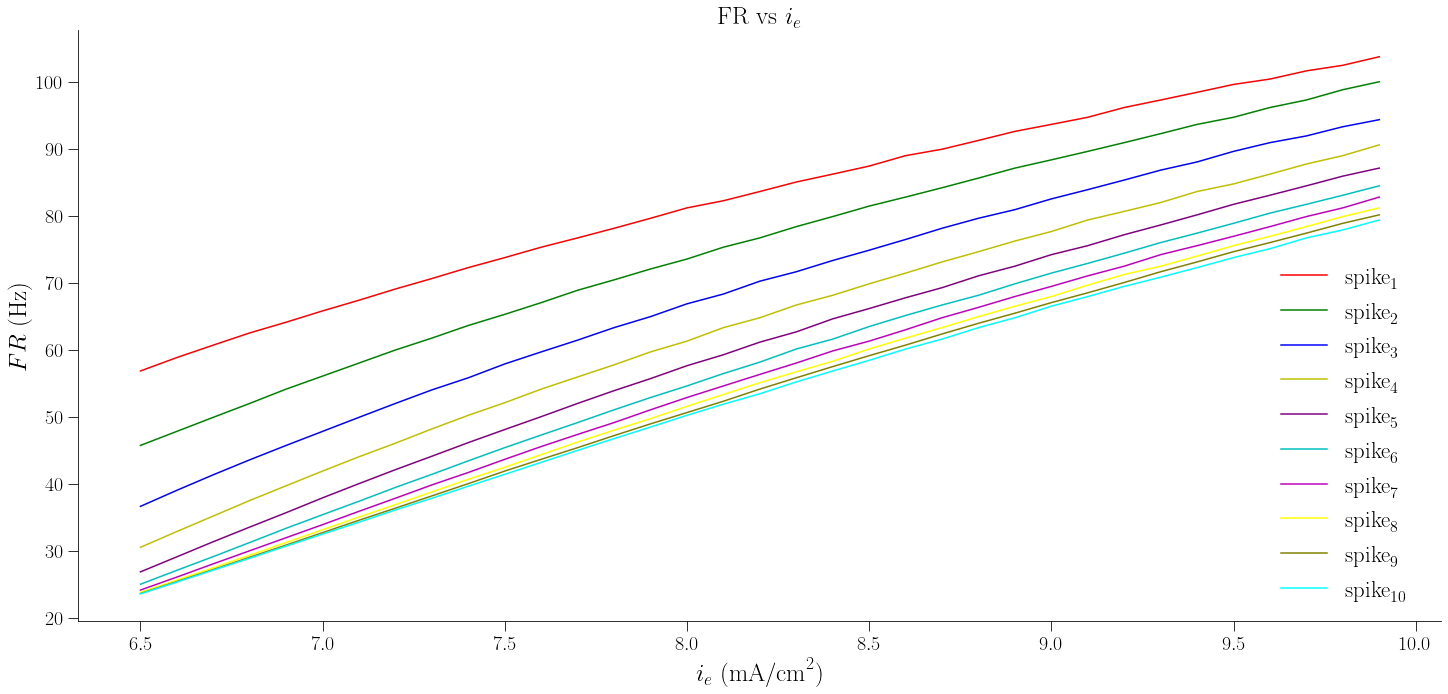

In [9]:
#################################  ### 00 ###

plt.rc('text', usetex=True)

#################################
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

#################################  ### 01 ###
fontsize = 25
labelsize = 20
#################################

fig = plt.figure(constrained_layout=True, figsize=(20,18));

spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax1.plot(Inten, FR_v1, 'r', label= r"$\textrm{spike}_1$")
f_ax1.plot(Inten, FR_v2, 'g', label= r"$\textrm{spike}_2$")
f_ax1.plot(Inten, FR_v3, 'b', label= r"$\textrm{spike}_3$")
f_ax1.plot(Inten, FR_v4, 'y', label= r"$\textrm{spike}_4$")
f_ax1.plot(Inten, FR_v5, 'purple', label= r"$\textrm{spike}_5$")
f_ax1.plot(Inten, FR_v6, 'c', label= r"$\textrm{spike}_6$")
f_ax1.plot(Inten, FR_v7, 'm', label= r"$\textrm{spike}_7$")
f_ax1.plot(Inten, FR_v8, 'yellow', label= r"$\textrm{spike}_8$")
f_ax1.plot(Inten, FR_v9, 'olive', label= r"$\textrm{spike}_9$")
f_ax1.plot(Inten, FR_v10, 'aqua', label= r"$\textrm{spike}_{10}$")

f_ax1.set_xlabel(r'$i_{e} \textrm{ (mA/cm}^{2})$', fontsize=fontsize)
f_ax1.set_ylabel(r'$FR \textrm{ (Hz)}$',fontsize=fontsize)
f_ax1.set_title(r'$\textrm{FR vs } i_{e}$',fontsize=fontsize)

f_ax1.legend(bbox_transform=f_ax1.transData, bbox_to_anchor=(10, 74), ncol=1, borderaxespad=0, 
             frameon=False, fontsize=23)


#plt.legend(fontsize='large', frameon=False, loc='lower right')

axes_fig = [f_ax1] # irudiak dazkanaren arabera

for i in axes_fig:
    i.tick_params(axis='y', labelsize=labelsize, pad=5, length=10);
    i.tick_params(axis='x', labelsize=labelsize, pad=5, length=10);

plt.savefig('RS_Ereduko_Firing_Rate.pdf', format='pdf', dpi=180,bbox_inches="tight");
